In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as interp
from matplotlib import cm
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
from scipy.interpolate import RectBivariateSpline
from scipy.stats import kurtosis, skew
import scipy.optimize as optimize
from iminuit import Minuit

from ipywidgets import *

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import sncosmo
from sncosmo.salt2utils import BicubicInterpolator

from astropy.table import Table

%matplotlib inline

# Read the data

In [2]:
# file data paths
data_path = ".//SN_surfaces//"
file_names = glob.glob(data_path+"*.dat")
# rewrite the names
for i in range(0, len(file_names)):
    file_names[i] = file_names[i][15:]
print("Total files in path: ", len(file_names))

Total files in path:  160


# Training the model

## Principal Component Analysis

In [3]:
sn_train=file_names

In [4]:
TRAIN_DATASET=[]

# read the training dataset
for i in range(0, len(sn_train)):
    SN = pd.read_csv(".//SN_surfaces//"+str(sn_train[i]),
                           header=None,
                           sep="\s+",
                           names=["phase", "wave", "flux", "eflux"])
    TRAIN_DATASET.append(np.array(SN["flux"]))

In [5]:
len(TRAIN_DATASET)

160

In [6]:
# Number of components 
N=10

In [7]:
np.random.random(42)
# apply pca with N components
pca = PCA(N)
pca.fit(TRAIN_DATASET);

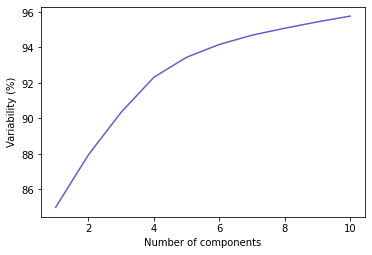

In [8]:
plt.plot(np.linspace(1, 10, 10, dtype=int), np.cumsum(pca.explained_variance_ratio_)*100, color="slateblue")
plt.xlabel('Number of components')
plt.ylabel('Variability (%)')
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(left=0.15)

#plt.savefig("/home/joao/Desktop/variabilidade_acumulada.png", dpi = 200)   # save the figure to file

In [9]:
print("Explained variance in 3 components: ", pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2])

Explained variance in 3 components:  0.9034467222395899


In [10]:
# grid plot
x_grid = np.linspace(-10,50,61)
y_grid = np.linspace(3500,8000, 451)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

### Mean surface

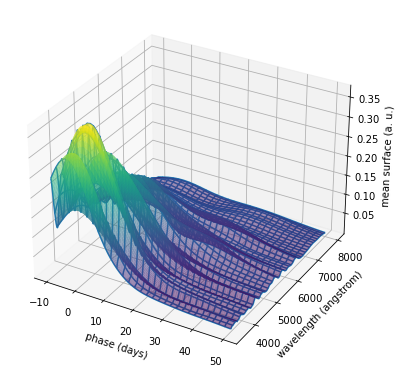

In [11]:
#matplotlib notebook

Z = interp.griddata((SN["phase"],SN["wave"]),pca.mean_,(B1,B2),method='cubic')
#Z = splinemean(B1, B2)
fig = plt.figure(figsize=(7, 5))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
ax.set_xlabel("phase (days)")
ax.set_ylabel("wavelength (angstrom)")
ax.set_zlabel("mean surface (a. u.)")

plt.show()

### Components

In [12]:
optionslist = []

for i in range(0,N):
    
    optionslist.append(i)

<IPython.core.display.Javascript object>


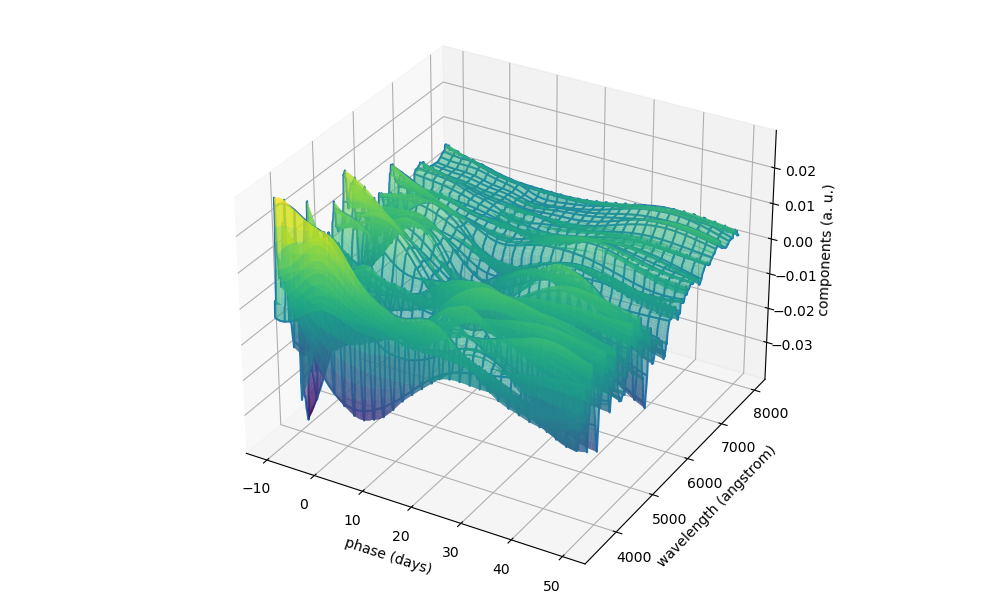

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Out…

In [16]:
%matplotlib notebook

fig = plt.figure(figsize=(10, 6))
ax = axes3d.Axes3D(fig)

def update_graph(i):
    
    ax.clear()

    Z = interp.griddata((SN["phase"],SN["wave"]),pca.components_[i],(B1,B2),method='cubic')
    #Z = splinemean(B1, B2)
    ax.plot_wireframe(B1, B2, Z)
    ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
    ax.set_xlabel("phase (days)")
    ax.set_ylabel("wavelength (angstrom)")
    ax.set_zlabel("components (a. u.)")


    plt.show()
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)

widgets.interactive(update_graph,i = i)

In [17]:
# training grid
TEMP_PHASE_GRID = np.linspace(-10, 50, 61, dtype=int)
TEMP_WAVE_GRID = np.linspace(3500, 8500, 501, dtype=int)

In [18]:
# 2d grid
X_GRID = []
Y_GRID = []
for i in range(0, len(TEMP_PHASE_GRID)):
    for j in range(0, len(TEMP_WAVE_GRID)):
        X_GRID.append(TEMP_PHASE_GRID[i])
        Y_GRID.append(TEMP_WAVE_GRID[j])

In [19]:
# Templates dataset in a pandas dataframe
templates = []
for i in range(N):
    data = [np.array(X_GRID), np.array(Y_GRID), (pca.components_[i].reshape(501, 61).T).reshape(1, len(pca.components_[i]))[0]] # to save as a pandas dataframe
    templates.append(pd.DataFrame(np.array(data).T, columns=["phase", "wave", "flux"]))
    
print("number of templates generated: ", len(templates))

number of templates generated:  10


# Models Fit

### SALT2

In [20]:
def salt2_fit(data):
    # create a model
    model = sncosmo.Model(source='salt2') # sncosmo model (salt2)
    model.set(z=data.meta["Z_HELIO"])
    
    # run the fit
    result, fitted_model = sncosmo.fit_lc(data, model, ['t0','x0', 'x1', 'c'], modelcov=False)  # bounds on parameters (if any)
    #print("chi^2 minimum/dof (SALT2): ", result.chisq/result.ndof)
    
    #sncosmo.plot_lc(data, model=fitted_model, errors=result.errors);
    
    return fitted_model, result

### Single Expansion Model (Using PCA)

In [21]:
from scipy.interpolate import RectBivariateSpline

# A new class for sncosmo
class EXP(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2']
    param_names_latex = ['x_0', 'x_1', 'x_2']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, name='EXP', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2)

        self._parameters = np.array([1, 0, 0])  # initial guess
        

    def _flux(self, phase, wave):
        
        x0, x1, x2 = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave))

### Single Expansion Model (Using PCA) (com todas 10 componentes)

In [22]:
from scipy.interpolate import RectBivariateSpline

# A new class for sncosmo
class EXP10(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2','x3','x4','x5','x6','x7','x8','x9']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, flux3, flux4, flux5, flux6, flux7, flux8, flux9, name='EXP10', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2)
        self._model_flux3  = BicubicInterpolator(phase, wave, flux3)
        self._model_flux4  = BicubicInterpolator(phase, wave, flux4)
        self._model_flux5  = BicubicInterpolator(phase, wave, flux5)
        self._model_flux6  = BicubicInterpolator(phase, wave, flux6)
        self._model_flux7  = BicubicInterpolator(phase, wave, flux7)
        self._model_flux8  = BicubicInterpolator(phase, wave, flux8)
        self._model_flux9  = BicubicInterpolator(phase, wave, flux9)

        self._parameters = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # initial guess
        

    def _flux(self, phase, wave):
        
        x0, x1, x2, x3, x4, x5, x6, x7, x8, x9 = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave) +  x3 * self._model_flux3(phase, wave) +  x4 * self._model_flux4(phase, wave)  +  x5 * self._model_flux5(phase, wave) +  x6 * self._model_flux6(phase, wave) +  x7 * self._model_flux7(phase, wave) +  x8 * self._model_flux8(phase, wave) +  x9 * self._model_flux9(phase, wave))

## Reading JLA Light curve data

In [23]:
lc_jla=glob.glob("JLA_LCS/lc-*.list")
sn_names_jla=[lc_jla[i][11:-5] for i in range(len(lc_jla))]

In [24]:
PHOTOMETRY_DATASET_TEST=[sncosmo.read_lc(lc_jla[i],format="salt2") for i in range(len(lc_jla))]

In [25]:
PHOTOMETRY_DATASET_TEST

[<Table length=250>
    Date       Flux       Fluxerr        ZP       Filter    MagSys
  float64    float64      float64     float64     str13      str5 
 --------- ----------- ------------- --------- ------------ ------
 53640.447  0.68139379  0.0069032005 15.358495 KEPLERCAM::B  VEGA2
 53641.466  0.80130559  0.0073800245 15.358495 KEPLERCAM::B  VEGA2
 53645.511   1.0476065  0.0096484556 15.358495 KEPLERCAM::B  VEGA2
 53650.432  0.95103866  0.0087590661 15.358495 KEPLERCAM::B  VEGA2
 53656.417  0.61574114  0.0056709759 15.358495 KEPLERCAM::B  VEGA2
 53666.485  0.18188554  0.0026802653 15.358495 KEPLERCAM::B  VEGA2
 53667.402  0.16481555  0.0027323121 15.358495 KEPLERCAM::B  VEGA2
 53667.419   0.1738594  0.0027221166 15.358495 KEPLERCAM::B  VEGA2
 53669.505  0.13372056  0.0028326025 15.358495 KEPLERCAM::B  VEGA2
 53676.377 0.081470085  0.0021759845 15.358495 KEPLERCAM::B  VEGA2
       ...         ...           ...       ...          ...    ...
 53714.283 0.048032459  0.0015040884 14.95

# Light Curve Fits

In [26]:
gridx = np.linspace(-10, 50, 61)
gridy = np.linspace(3500, 8500, 501)

# templates reshaped
M0_reshape = np.array(templates[0]["flux"]).reshape(61, 501) 
M1_reshape = np.array(templates[1]["flux"]).reshape(61, 501)
M2_reshape = np.array(templates[2]["flux"]).reshape(61, 501)
M3_reshape = np.array(templates[3]["flux"]).reshape(61, 501)
M4_reshape = np.array(templates[4]["flux"]).reshape(61, 501)
M5_reshape = np.array(templates[5]["flux"]).reshape(61, 501)
M6_reshape = np.array(templates[6]["flux"]).reshape(61, 501)
M7_reshape = np.array(templates[7]["flux"]).reshape(61, 501)
M8_reshape = np.array(templates[8]["flux"]).reshape(61, 501)
M9_reshape = np.array(templates[9]["flux"]).reshape(61, 501)
c = pd.read_csv(".//Templates//salt2_colour_law_guy2010.dat", header = None, sep = "\s+") # color term
c.columns = ["wave", "ext"]

#exp_mom = EXP_MOM(gridx, gridy, name='EXP_MOM')

## SALT2 x EXP

In [27]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [28]:
def update_graph(i):
    
    exp = EXP(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, name='EXP')
    model = sncosmo.Model(source=exp)
    model.set(z=PHOTOMETRY_DATASET_TEST[i].meta["Z_HELIO"])

    bandpasses=pd.Series(PHOTOMETRY_DATASET_TEST[i]["Filter"]).unique()

    try:
        [sncosmo.get_bandpass(bandpasses[i]) for i in range(len(bandpasses))]
        pass

    except: 
        for band in bandpasses:
            x_plane=PHOTOMETRY_DATASET_TEST[i].meta["X_FOCAL_PLANE"]
            y_plane=PHOTOMETRY_DATASET_TEST[i].meta["Y_FOCAL_PLANE"]
            r=(x_plane**2.+y_plane**2.)**(1./2.)
    
            b=sncosmo.get_bandpass(band, r)    
            sncosmo.register(b, band)
           
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['t0','x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## SALT2 x EXP10

In [ ]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [ ]:
def update_graph(i):
    
    exp = EXP10(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, name='EXP10')
    model = sncosmo.Model(source=exp)

    model.set(z=PHOTOMETRY_DATASET_TEST[i].meta["Z_HELIO"])

    bandpasses=pd.Series(PHOTOMETRY_DATASET_TEST[i]["Filter"]).unique()

    try:
        [sncosmo.get_bandpass(bandpasses[i]) for i in range(len(bandpasses))]
        pass

    except: 
        for band in bandpasses:
            x_plane=PHOTOMETRY_DATASET_TEST[i].meta["X_FOCAL_PLANE"]
            y_plane=PHOTOMETRY_DATASET_TEST[i].meta["Y_FOCAL_PLANE"]
            r=(x_plane**2.+y_plane**2.)**(1./2.)
    
            b=sncosmo.get_bandpass(band, r)    
            sncosmo.register(b, band)
    
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['t0','x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP10): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_salt2)
    #print(result_exp)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP10"],
                    color="k")
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

## EXP(3)x EXP10

In [ ]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [ ]:
def update_graph(i):
    
    exp1 = EXP(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, name='EXP')
    model1 = sncosmo.Model(source=exp1)
    model1.set(z=PHOTOMETRY_DATASET_TEST[i].meta["Z_HELIO"])

    exp2 = EXP10(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, name='EXP10')
    model2 = sncosmo.Model(source=exp2)
    model2.set(z=PHOTOMETRY_DATASET_TEST[i].meta["Z_HELIO"])
    
    bandpasses=pd.Series(PHOTOMETRY_DATASET_TEST[i]["Filter"]).unique()

    try:
        [sncosmo.get_bandpass(bandpasses[i]) for i in range(len(bandpasses))]
        pass

    except: 
        for band in bandpasses:
            x_plane=PHOTOMETRY_DATASET_TEST[i].meta["X_FOCAL_PLANE"]
            y_plane=PHOTOMETRY_DATASET_TEST[i].meta["Y_FOCAL_PLANE"]
            r=(x_plane**2.+y_plane**2.)**(1./2.)
    
            b=sncosmo.get_bandpass(band, r)    
            sncosmo.register(b, band)
    
    
    result_exp1, model_exp1 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model1, ['t0','x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    #print("chi^2 minimum/dof (EXP): ", result_exp1.chisq/result_exp1.ndof)
    
    result_exp2, model_exp2 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model2, ['t0','x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)  # bounds on parameters (if any)
    #print("chi^2 minimum/dof (EXP10): ", result_exp2.chisq/result_exp2.ndof)

    print(result_exp1.keys())
    print(result_exp1.param_names)
    print(result_exp1.parameters)
    print(result_exp1.chisq/result_exp1.ndof)
    
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_exp1, model_exp2],
                    errors=[result_exp1.errors, result_exp2.errors],
                    model_label=["EXP(3)", "EXP10"],
                    color="k")
    
    #plt.savefig('EXP_x_EXP10_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

# Finding corrrelations between EXP(3) x EXP10 model coefficients 

In [32]:
def parametros_ajustes(ii):
    """
    i:SN train index
    """   
    exp1 = EXP(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, name='EXP')
    exp2 = EXP10(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, name='EXP10')
        
    model1 = sncosmo.Model(source=exp1)
    model2 = sncosmo.Model(source=exp2)

    model1.set(z=PHOTOMETRY_DATASET_TEST[ii].meta["Z_HELIO"])
    model2.set(z=PHOTOMETRY_DATASET_TEST[ii].meta["Z_HELIO"])
    
    bandpasses=pd.Series(PHOTOMETRY_DATASET_TEST[ii]["Filter"]).unique()

    try:
        [sncosmo.get_bandpass(bandpasses[k]) for k in range(len(bandpasses))]
        pass

    except: 
        for band in bandpasses:
            x_plane=PHOTOMETRY_DATASET_TEST[ii].meta["X_FOCAL_PLANE"]
            y_plane=PHOTOMETRY_DATASET_TEST[ii].meta["Y_FOCAL_PLANE"]
            r=(x_plane**2.+y_plane**2.)**(1./2.)
    
            b=sncosmo.get_bandpass(band, r)    
            sncosmo.register(b, band)
    
        
    result_exp1, model_exp1 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[ii], model1, ['t0','x0', 'x1', 'x2'], modelcov=False)
    result_exp2, model_exp2 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[ii], model2, ['t0','x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)

    return result_exp1.parameters[2], result_exp1.parameters[3], result_exp1.parameters[4], result_exp2.parameters[2], result_exp2.parameters[3], result_exp2.parameters[4], result_exp2.parameters[5], result_exp2.parameters[6], result_exp2.parameters[7], result_exp2.parameters[8], result_exp2.parameters[9], result_exp2.parameters[10], result_exp2.parameters[11]

In [33]:
param_ajuste = pd.DataFrame(data=np.zeros(shape=(len(PHOTOMETRY_DATASET_TEST), 13)), columns=["x0_exp3", "x1_exp3", "x2_exp3", "x0_exp10", "x1_exp10", "x2_exp10", "x3_exp10", "x4_exp10", "x5_exp10", "x6_exp10", "x7_exp10", "x8_exp10", "x9_exp10"])
for j in range(0, len(PHOTOMETRY_DATASET_TEST)):
    x0_exp, x1_exp, x2_exp, x0_exp10, x1_exp10, x2_exp10, x3_exp10, x4_exp10, x5_exp10, x6_exp10, x7_exp10, x8_exp10, x9_exp10  = parametros_ajustes(j)
    #param_ajuste["x0_exp3"][i] = -2.5*np.log10(x0_exp)
    param_ajuste["x0_exp3"][i] = x0_exp
    param_ajuste["x1_exp3"][i] = x1_exp
    param_ajuste["x2_exp3"][i] = x2_exp
    #param_ajuste["x0_exp10"][i] = -2.5*np.log10(x0_exp10)
    param_ajuste["x0_exp10"][i] = x0_exp10
    param_ajuste["x1_exp10"][i] = x1_exp10
    param_ajuste["x2_exp10"][i] = x2_exp10
    param_ajuste["x3_exp10"][i] = x3_exp10
    param_ajuste["x4_exp10"][i] = x4_exp10
    param_ajuste["x5_exp10"][i] = x5_exp10
    param_ajuste["x6_exp10"][i] = x6_exp10
    param_ajuste["x7_exp10"][i] = x7_exp10
    param_ajuste["x8_exp10"][i] = x8_exp10
    param_ajuste["x9_exp10"][i] = x9_exp10

param_ajuste.head()


/home/cassia/anaconda3/envs/da38/lib/python3.8/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: keplercam::i, keplercam::us, keplercam::b(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/da38/lib/python3.8/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: sdss::g, sdss::u(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/da38/lib/python3.8/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: megacampsf::g at 11.598235, megacampsf::r at 11.598235(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/da38/lib/python3.8/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: 4shooter2::b, 4shooter2::i, 4shooter2::us, 4shooter2::r(out of model wavel

DataQualityError: No data points with S/N > 5.0. Initial guessing failed.

In [ ]:
exp3_param_names = {
    0:"x0_exp3",
    1:"x1_exp3",
    2:"x2_exp3"
}

exp3_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$x_2$"
}
exp10_param_names = {
    0:"x0_exp10",
    1:"x1_exp10",
    2:"x2_exp10",
    3:"x3_exp10",
    4:"x4_exp10",
    5:"x5_exp10",
    6:"x6_exp10",
    7:"x7_exp10",
    8:"x8_exp10",
    9:"x9_exp10"
}

exp10_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$x_2$",
    3:"$x_3$",
    4:"$x_4$",
    5:"$x_5$",
    6:"$x_6$",
    7:"$x_7$",
    8:"$x_8$",
    9:"$x_9$"
}

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=10, figsize=(12,36))
for i in range(10):
    for j in range(3):
        ax[i, j].plot(param_ajuste[exp10_param_names[i]], param_ajuste[exp3_param_names[j]], 'k.')#, label=str(round(np.corrcoef(df[salt2_param_names[i]], df[exp_param_names[j]])[0][1]*100, 1)))
        ax[i, j].annotate("ρ = "+str(round(np.corrcoef(param_ajuste[exp10_param_names[i]], param_ajuste[exp3_param_names[j]])[0][1]*100, 1)), xy=(0.9, .2), xycoords='axes fraction',
                          size=14, ha='right', va='top',
                          bbox=dict(boxstyle='round', fc='w'))
        if j == 0:
            ax[i, j].set_ylabel(exp10_param_latex[i])
        if i == 9:
            ax[i, j].set_xlabel(exp3_param_latex[j])
plt.savefig('correlation.pdf')

In [ ]:
correlation_matrix=pd.DataFrame(data=np.zeros(shape=(10, 3)), index=["x0_exp10", "x1_exp10", "x2_exp10", "x3_exp10", "x4_exp10", "x5_exp10", "x6_exp10", "x7_exp10", "x8_exp10", "x9_exp10"],columns=["x0_exp3","x1_exp3","x2_exp3"])
for i in range(10):
    for j in range(3):
        correlation_matrix[exp3_param_names[j]][exp10_param_names[i]]=round(np.corrcoef(param_ajuste[exp10_param_names[i]], param_ajuste[exp3_param_names[j]])[0][1], 4)

In [ ]:
correlation_matrix

In [ ]:
new_M0=np.zeros(shape=M0_reshape.shape)
new_M1=np.zeros(shape=M1_reshape.shape)
new_M2=np.zeros(shape=M2_reshape.shape)
M=[M0_reshape,M1_reshape,M2_reshape,M3_reshape,M4_reshape,M5_reshape,M6_reshape,M7_reshape,M8_reshape,M9_reshape]
for i in range(10):
    new_M0+=M[i]*correlation_matrix["x0_exp3"][exp10_param_names[i]]
    new_M1+=M[i]*correlation_matrix["x1_exp3"][exp10_param_names[i]]
    new_M2+=M[i]*correlation_matrix["x2_exp3"][exp10_param_names[i]]

## SALT2 x New EXP(3)

In [ ]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [ ]:
def update_graph(i):
    
    exp = EXP(gridx, gridy, new_M0, new_M1, new_M2, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0., t0=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    #plt.savefig('SALT2_x_NovoEXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

## New EXP(3) x EXP10

In [ ]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [ ]:
def update_graph(i):
    
    exp1 = EXP(gridx, gridy, new_M0, new_M1, new_M2, name='EXP')
    model1 = sncosmo.Model(source=exp1)
    model1.set(z=0., t0=0)

    exp2 = EXP10(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, name='EXP10')
    model2 = sncosmo.Model(source=exp2)
    model2.set(z=0., t0=0)
    
    result_exp1, model_exp1 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model1, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    #print("chi^2 minimum/dof (EXP): ", result_exp1.chisq/result_exp.ndof)
    
    result_exp2, model_exp2 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model2, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)  # bounds on parameters (if any)
    #print("chi^2 minimum/dof (EXP10): ", result_exp2.chisq/result_exp.ndof)

    print(result_exp1.keys())
    
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_exp1, model_exp2],
                    errors=[result_exp1.errors, result_exp2.errors],
                    model_label=["Novo EXP(3)", "EXP10"],
                    color="k")
    #plt.savefig('NovoEXP_x_EXP10_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

## New EXP(3) x Old EXP(3)

In [ ]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [ ]:
def update_graph(i):
    
    exp1 = EXP(gridx, gridy, new_M0, new_M1, new_M2, name='EXP')
    model1 = sncosmo.Model(source=exp1)

    exp2 = EXP(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, name='EXP')
    model2 = sncosmo.Model(source=exp2)

    model1.set(z=0., t0=0)
    model2.set(z=0., t0=0)
    
    result_exp1, model_exp1 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model1, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    result_exp2, model_exp2 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model2, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)

    #print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_exp1, model_exp2],
                    errors=[result_exp1.errors, result_exp2.errors],
                    model_label=["novo EXP(3)", "antigo EXP(3)"],
                    color="k")
    #plt.savefig('NovoEXP_x_AntigoEXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

In [ ]:
(new_M0-M0_reshape)/M0_reshape